# <center> Portfolio Exam 3</center>
# <center>Reinforcement Learning    -    BlackJack Player</center>

This portfolio exam is all about a self-learning BackJack player based on Reinforcement Learning methods. The basis of Reinforcement Learning are the methods from [2]. Basic concepts of the BackJack card game, various rule variations, and card counting methods can be found in [3].

# Task P3.1

Realize a Reinforcement Learning implementation of a self-learning BlackJack player in a programming language of your choice. This implementation provides the basis for the paper from Task P3.2. It shall learn optimal policies for at least the following scenarios: 

1. The Basic Strategy from [3]. 

2. The Complete Point-Count System from [3]. 

3. In addition to the basic rules, two rule variations of your choice shall be examined for their influence on the strategies from (1.) and (2.). 

4. Consider improving the system from (2.) to be able to achieve higher profits on average. 

Note: Your system does not have to be suitable for humans. It may therefore be relatively complicated, e.g. with respect to card counting. 

What profit can be expected for the different scenarios? 

You can re-use your previous implementations from the Reinforcement Learning exercises. For example, the environment implementation from the Chapter 3 exercises. 

The deliverable for this task is the commented source code of your implementation and all logles that contributed to the results in Task P3.2. Do not use an external Reinforcement Learning framework.

### BlackJack Environment

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from collections import defaultdict

In [2]:
class BlackjackEnvironment:
    def __init__(self):
        # Initializing
        self.deck = self.create_new_deck()
        self.player_cards = []
        self.dealer_cards = []
        self.split_cards = []
        self.has_doubled_down = False
        
        self.rewards = []  
        self.hand_lengths = []  
        
        self.reset_game()

    def create_new_deck(self):
        # generating a new deck of cards and shuffle
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        return [str(value) + '_' + suit for value in values for suit in suits]
    
    def draw_random_card(self):
        # pick a random card from the deck
        return self.deck.pop(random.randint(0, len(self.deck) - 1))

    def reset_game(self):
        # reset the game state and draw initial cards for player and dealer
        self.deck = self.create_new_deck()
        self.player_cards = [self.draw_random_card(), self.draw_random_card()]
        self.dealer_cards = [self.draw_random_card(), self.draw_random_card()]

    def get_card_value(self, card):
        # get the value of a card
        value = card.split('_')[0]
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def calculate_hand_value(self, hand):
        # calculate the total value of a hand
        value = sum(self.get_card_value(card) for card in hand)
        if value > 21 and any(card.startswith('ace') for card in hand):
            value -= 10
        return value
    
    def has_soft_hand(self, hand):
        # check if a hand is soft (contains an ace counted as 11)
        return any(card.startswith('ace') for card in hand) and self.calculate_hand_value(hand) <= 21 

    def check_if_busted(self, hand):
        # check if a hand is busted (value exceeds 21)
        return self.calculate_hand_value(hand) > 21

    def play_dealer_hand(self):
        # dealer plays according to the rules (hit until reaching at least 17)
        while self.calculate_hand_value(self.dealer_cards) < 17:
            self.dealer_cards.append(self.draw_random_card())
    #soft17 rule         
#     def play_dealer_hand(self):
#     # dealer hits until reaching a hard 17 or stands on a soft 17
#         while self.calculate_hand_value(self.dealer_cards) < 17 or (self.calculate_hand_value(self.dealer_cards) == 17 and self.has_soft_hand(self.dealer_cards)):
#             if self.calculate_hand_value(self.dealer_cards) == 17 and self.has_soft_hand(self.dealer_cards):
#                 break  # stand on soft 17
#             self.dealer_cards.append(self.draw_random_card())

                
    def check_if_pair(self, hand):
        # check if the player's hand is a pair (both cards have the same value)
        if len(hand) == 2:
            return hand[0].split('_')[0] == hand[1].split('_')[0]
        
    def execute_action(self, action):
        # perform the given action ('h' for hit, 's' for stand, 'p' for split, 'd' for double down) and return the next state, reward, and if the game has ended
        if action == 'h':
            # player chooses to hit and draws a card
            self.player_cards.append(self.draw_random_card())
            if self.check_if_busted(self.player_cards):
                self.rewards.append(-1)  # update rewards
                self.hand_lengths.append(len(self.player_cards))  # update hand lengths
                if self.has_doubled_down:
                    return 'terminal', -2, True
                else:
                    # player is busted and loses the game
                    return 'terminal', -1, True
                    
        elif action == 's':
            # player chooses to stand and the dealer plays their turn
            self.play_dealer_hand()
            player_value = self.calculate_hand_value(self.player_cards)
            dealer_value = self.calculate_hand_value(self.dealer_cards)

            if self.check_if_busted(self.dealer_cards) or player_value > dealer_value:
                # player wins if the dealer is busted or has a lower hand value
                self.rewards.append(1)  # update rewards
                self.hand_lengths.append(len(self.player_cards))  # update hand lengths
                return 'terminal', 1, True
            elif dealer_value > player_value:
                # player loses if the dealer has a higher hand value
                self.rewards.append(-1)  # update rewards
                self.hand_lengths.append(len(self.player_cards))  # update hand lengths
                return 'terminal', -1, True
            else:
                # the game is a tie if the player and dealer have the same hand value
                self.rewards.append(0)  # update rewards
                self.hand_lengths.append(len(self.player_cards))  # update hand lengths
                return 'terminal', 0, True
            
        elif action == 'p' and self.check_if_pair(self.player_cards):
            # chooses to split and draws a card for each hand
            self.split_cards = [self.player_cards.pop()]
            self.player_cards.append(self.draw_random_card())
            self.split_cards.append(self.draw_random_card())
            return self.get_current_state(), 0, False
            
        elif action == 'd':
            # player chooses to double down and draws a card
            self.has_doubled_down = True
            self.player_cards.append(self.draw_random_card())
            if self.check_if_busted(self.player_cards):
                # player loses twice their bet 
                self.rewards.append(-1)  # update rewards
                self.hand_lengths.append(len(self.player_cards))  # update hand lengths
                return  'terminal', -2, True
            return self.get_current_state(), 0, False
        
        # if the game is not over, return the current state, reward of 0, and False for not done
        return self.get_current_state(), 0, False

    def get_current_state(self):
        player_value = self.calculate_hand_value(self.player_cards)
        dealer_up_card_value = self.get_card_value(self.dealer_cards[0])
        return (player_value, dealer_up_card_value, self.has_soft_hand(self.player_cards), len(self.split_cards) > 0, self.has_doubled_down)

### Selecting Action Randomly

In [3]:
def play_episodes(env, num_episodes):
    wins, losses, draws = 0, 0, 0

    for _ in range(num_episodes):
        env.reset_game()
        episode_reward = 0

        while True:# randomly choose an action ('h' for hit, 's' for stand)
            action = random.choice(['h', 's'])
            _, reward, done = env.execute_action(action)
            episode_reward += reward

            if done:
                break

        if episode_reward > 0:
            wins += 1
        elif episode_reward < 0:
            losses += 1
        else:
            draws += 1

    winning_rate = wins / num_episodes
    losing_rate = losses / num_episodes
    draw_rate = draws / num_episodes

    print(f"Random selecting - Winning rate: {winning_rate:.2f}, Losing rate: {losing_rate:.2f}, Draw rate: {draw_rate:.2f}")

env = BlackjackEnvironment()
num_episodes = 10000
play_episodes(env, num_episodes)

Random selecting - Winning rate: 0.28, Losing rate: 0.68, Draw rate: 0.04


### Basic Strategy

In [4]:
class BasicStrategyAgent:
    def __init__(self, environment):
        # Initialize the agent with the given environment
        self.environment = environment

    def choose_action(self, state):
        # select action based on the player's and dealer's hand values using basic rules
        player_value, dealer_value, _, _, _ = state

        if player_value <= 11:
            return 'h'  # Hit if player value is 11 or less
        elif player_value >= 17:
            return 's'  # Stand if player value is 17 or more
        elif dealer_value >= 7:
            return 'h'  # Hit if dealer's up card is 7 or more
        else:
            return 's'  # Otherwise, stand

    def play(self, num_games=10000):
        # Play the specified number of games and track win/loss/tie rates
        wins, losses, draws = 0, 0, 0

        for _ in range(num_games):
            # Reset the game environment at the start of each game
            self.environment.reset_game()
            state = self.environment.get_current_state()
            done = False

            while not done:
                # Choose an action based on the current state
                action = self.choose_action(state)
                # Execute the selected action and get state, reward
                state, reward, done = self.environment.execute_action(action)

            # Update win, loss, or tie counters based on the game outcome
            if reward > 0:
                wins += 1
            elif reward < 0:
                losses += 1
            else:
                draws += 1

        # Calculate win, loss, and tie rates
        winning_rate = wins / num_games
        losing_rate = losses / num_games
        draw_rate = draws / num_games

        return winning_rate, losing_rate, draw_rate

environment = BlackjackEnvironment()
basic_agent = BasicStrategyAgent(environment)
winning_rate, losing_rate, draw_rate = basic_agent.play(num_games=100000)
print(f"Basic Strategy without Q learning - Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")


Basic Strategy without Q learning - Winning rate: 0.4284, Losing rate: 0.4822, Draw rate: 0.0895


### Introducing Reinforcement Learning to train the agents: 

#### Basic Strategy - Q Learning(epsilon greedy) and SARSA 

In [5]:
#Qlearning
class QLearningAgent:
    def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha=0.01, gamma=0.99):
        # initialize the Q-learning agent with the given environment and learning parameters
        self.environment = environment
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = initial_epsilon  # exploration rate
        self.num_episodes = num_episodes  # number of episodes to train
        self.epsilon_decay = epsilon_decay  # decay rate for epsilon
        self.final_epsilon = final_epsilon
        self.Q_values = {}  # Q-value dictionary mapping (state, action) pairs to Q-values
        self.epsilon_values = []

    def get_q_value(self, state, action):
        # get the Q-value for a given state-action pair
        return self.Q_values.get((state, action), 0)
    
    def select_action(self, state):
        # choose an action to take in the given state based on the current Q-values and exploration rate
        if np.random.random() < self.epsilon:
            # collect epsilon values
            self.epsilon_values.append(self.epsilon)
            # choose a random action with probability epsilon (exploration)
            return random.choice(['h', 's'])
        else:
            # choose the action with the highest Q-value (exploitation)
            return max(['h', 's'], key=lambda action: self.Q_values.get((state, action), 0))

    def update_q_value(self, state, action, next_state, reward):
        # update the Q-value table using the Q-learning update rule
        current_q = self.Q_values.get((state, action), 0)
        next_q = max(self.Q_values.get((next_state, a), 0) for a in ['h', 's'])
        temporal_difference = reward + self.gamma * next_q - current_q
        self.Q_values[(state, action)] = current_q + self.alpha * temporal_difference
    
    def decay_epsilon(self):
        # decay the epsilon value to reduce exploration over time
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    
    def train_agent(self, num_episodes):
        # train the Q-learning agent by running the algorithm for the specified number of episodes
        for episode in range(num_episodes):
            self.environment.reset_game()
            state = self.environment.get_current_state()
            done = False
            while not done:
                action = self.select_action(state)
                next_state, reward, done = self.environment.execute_action(action)
                self.update_q_value(state, action, next_state, reward)
                state = next_state  
            self.decay_epsilon()

In [6]:
#SARSA - change in update rule
class SARSAAgent:
    def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha=0.01, gamma=0.99):
        # initialize the SARSA agent with the given environment and learning parameters
        self.environment = environment
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = initial_epsilon  # exploration rate
        self.num_episodes = num_episodes  # number of episodes to train
        self.epsilon_decay = epsilon_decay  # decay rate for epsilon
        self.final_epsilon = final_epsilon
        self.Q_values = {}  # Q-value dictionary mapping (state, action) pairs to Q-values
        self.epsilon_values = []

    def get_q_value(self, state, action):
        # get the Q-value for a given state-action pair
        return self.Q_values.get((state, action), 0)
    
    def select_action(self, state):
        # choose an action to take in the given state based on the current Q-values and exploration rate
        if np.random.random() < self.epsilon:
            # collect epsilon values
            self.epsilon_values.append(self.epsilon)
            # choose a random action with probability epsilon (exploration)
            return random.choice(['h', 's'])
        else:
            # choose the action with the highest Q-value (exploitation)
            return max(['h', 's'], key=lambda action: self.Q_values.get((state, action), 0))

    def update_q_value(self, state, action, next_state, next_action, reward):
        # Get the current Q-value for the given state-action pair
        current_q = self.Q_values.get((state, action), 0)

        # Get the Q-value for the next state and the next action
        # This is the key difference from Q-learning, where we consider the Q-value of the next action
        next_q = self.Q_values.get((next_state, next_action), 0)

        # Calculate the temporal difference (TD) error
        # This is the difference between the reward plus the discounted Q-value of the next state-action pair and the current Q-value
        temporal_difference = reward + self.gamma * next_q - current_q

        # Update the Q-value for the current state-action pair using the learning rate alpha
        # New Q-value = Old Q-value + alpha * TD error
        self.Q_values[(state, action)] = current_q + self.alpha * temporal_difference

    
    def decay_epsilon(self):
        # decay the epsilon value to reduce exploration over time
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    
    def train_agent(self, num_episodes):
        # train the SARSA agent by running the algorithm for the specified number of episodes
        for episode in range(num_episodes):
            self.environment.reset_game()
            state = self.environment.get_current_state()
            action = self.select_action(state)
            done = False
            while not done:
                next_state, reward, done = self.environment.execute_action(action)
                next_action = self.select_action(next_state)
                self.update_q_value(state, action, next_state, next_action, reward)
                state = next_state  
                action = next_action
            self.decay_epsilon()

Basic Strategy - Q-Learning Strategy - Winning rate: 0.4231, Losing rate: 0.4846, Draw rate: 0.0923


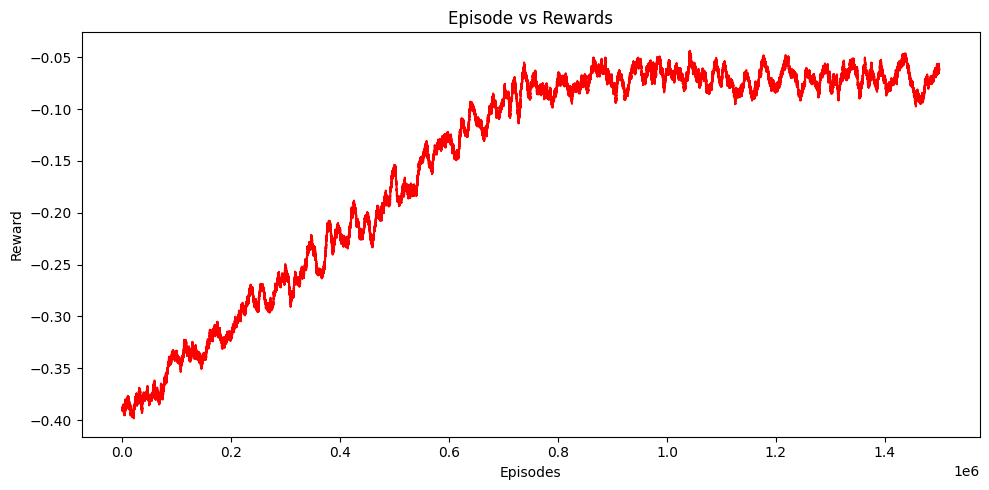

In [7]:
# training
num_episodes = 1500000
initial_epsilon = 1.0
epsilon_decay = initial_epsilon / (num_episodes / 2)
final_epsilon = 0.01
alpha = 0.1
gamma = 0.9

# Initialize the environment and the Q-learning agent
environment = BlackjackEnvironment()
agent = QLearningAgent(environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha, gamma)

#Please uncoment below line if you want to train using SARSA
#agent = SARSAAgent(environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha, gamma)
agent.train_agent(num_episodes)

# evaluate the performance of the trained agent over a number of games
num_games = 10000
win_count = 0
loss_count = 0
draw_count = 0

for _ in range(num_games):
    agent.environment.reset_game()
    state = agent.environment.get_current_state()
    game_done = False

    while not game_done:
        action = agent.select_action(state)
        state, reward, game_done = agent.environment.execute_action(action)

    if reward > 0:
        win_count += 1
    elif reward < 0:
        loss_count += 1
    else:
        draw_count += 1

winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

print(f"Basic Strategy - Q-Learning Strategy - Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")

#Please uncoment below line if you want to train using SARSA
#print(f"Basic Strategy - SARSA - Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")


# Plot the reward moving average
length_step = 10000
reward_moving_average = (np.convolve(np.array(environment.rewards).flatten(), np.ones(length_step), mode="valid") / length_step)
plt.figure(figsize=(10, 5))
plt.title('Episode vs Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(range(len(reward_moving_average)), reward_moving_average, color='red')
plt.tight_layout()
plt.show()


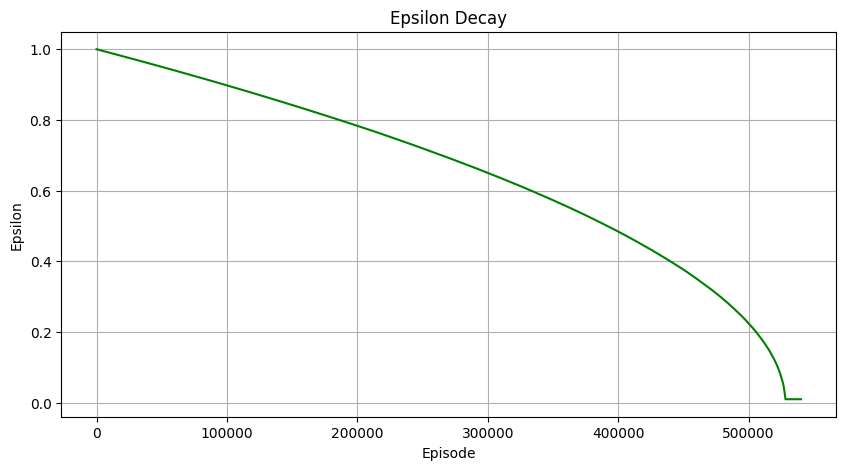

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(agent.epsilon_values, color='green')
ax.set_xlabel('Episode')
ax.set_ylabel('Epsilon')
ax.set_title('Epsilon Decay')
ax.grid()
plt.show()

#### Basic Strategy - Q Learning and SARSA - Hard and Soft hands rules using book rules

In [9]:
class QLearningAgent:
    def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay_rate, final_epsilon, learning_rate=0.1, discount_factor=0.99):
        # initialize the Q-learning agent with the given environment and learning parameters
        self.environment = environment
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.initial_epsilon = initial_epsilon
        self.epsilon = initial_epsilon
        self.num_episodes = num_episodes
        self.epsilon_decay_rate = epsilon_decay_rate
        self.final_epsilon = final_epsilon
        self.Q_values = defaultdict(lambda: [0, 0])
        self.errors = []
        self.epsilon_values = []

    def select_action(self, state):
        # choose an action based on the current state
        if self.environment.has_soft_hand(self.environment.player_cards):
            return self.choose_soft_action(state)
        else: 
            return self.choose_hard_action(state)

    def choose_hard_action(self, state):
        # choose an action based on a hard hand value as per the book rules - tabel 3.1
        player_hand_value = state[0]
        dealer_up_card_value = state[1]
        if player_hand_value <= 11:
            return 'h'
        elif player_hand_value >= 17: 
            return 's'
        elif 12 <= player_hand_value <= 16 and dealer_up_card_value >= 7:
            return 'h'
        elif 12 <= player_hand_value <= 17 and 4 <= dealer_up_card_value <= 6:
            return 's'
        elif 13 <= player_hand_value <= 17 and (dealer_up_card_value == 2 or dealer_up_card_value == 3):
            return 's'
        elif player_hand_value == 12 and (dealer_up_card_value == 2 or dealer_up_card_value == 3):
            return 'h'
        else:
            return 'h'  # default action

    def choose_soft_action(self, state):
        # choose an action based on a soft hand value as per the book rules - table 3.2
        player_hand_value = state[0]
        dealer_up_card_value = state[1]
        if player_hand_value <= 17:
            return 'h'
        elif player_hand_value == 18 and (dealer_up_card_value == 9 or dealer_up_card_value == 10):
            return 'h'
        else:
            return 's'

    def update_q_value(self, state, action, next_state, reward):
        # update the Q-value table using the Q-learning update rule
        action_index = 0 if action == 'h' else 1
        current_q = self.Q_values[state][action_index]
        next_q = max(self.Q_values[next_state])
        temporal_difference = reward + self.discount_factor * next_q - current_q
        self.Q_values[state][action_index] += self.learning_rate * temporal_difference
        self.errors.append(temporal_difference)
    
    def decay_epsilon(self, episode):
        # decay the epsilon value to reduce exploration over time
        self.epsilon = self.final_epsilon + (self.initial_epsilon - self.final_epsilon) * np.exp(-self.epsilon_decay_rate * episode)
        self.epsilon_values.append(self.epsilon)
    
    def train_agent(self, num_episodes):
        # train the Q-learning agent by running the algorithm for the specified number of episodes
        for episode in range(num_episodes):
            self.environment.reset_game()
            state = self.environment.get_current_state()
            game_done = False
            while not game_done:
                action = self.select_action(state)
                next_state, reward, game_done = self.environment.execute_action(action)
                self.update_q_value(state, action, next_state, reward)
                state = next_state  
            self.decay_epsilon(episode)

Basic Strategy - QLearning - Hard and Soft hand adjusted rules- Winning rate: 0.4225, Losing rate: 0.4863, Draw rate: 0.0912


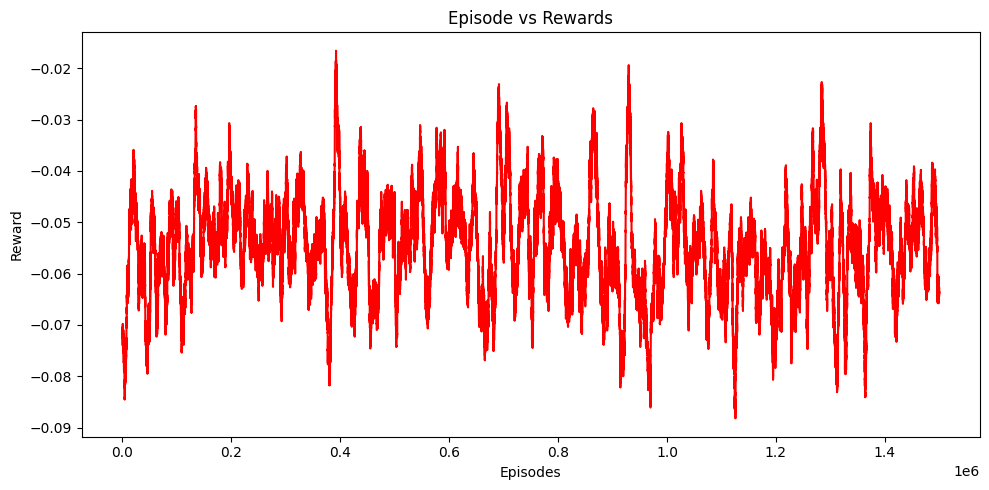

In [10]:
# training phase
num_episodes = 1500000
initial_epsilon = 1.0
epsilon_decay_rate = initial_epsilon / (num_episodes / 2)
final_epsilon = 0.01
learning_rate = 0.1
discount_factor = 0.9

# Initialize the environment and the Q-learning agent
environment = BlackjackEnvironment()
agent = QLearningAgent(environment, num_episodes, initial_epsilon, epsilon_decay_rate, final_epsilon, learning_rate, discount_factor)
agent.train_agent(num_episodes)

# evaluate the performance of the trained agent over a number of games
num_games = 10000
win_count = 0
loss_count = 0
draw_count = 0

for _ in range(num_games):
    agent.environment.reset_game()
    state = agent.environment.get_current_state()
    game_done = False

    while not game_done:
        action = agent.select_action(state)
        state, reward, game_done = agent.environment.execute_action(action)

    if reward > 0:
        win_count += 1
    elif reward < 0:
        loss_count += 1
    else:
        draw_count += 1

winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

print(f"Basic Strategy - QLearning - Hard and Soft hand adjusted rules- Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")


# Plot the reward moving average
length_step = 10000
reward_moving_average = (np.convolve(np.array(environment.rewards).flatten(), np.ones(length_step), mode="valid") / length_step)
plt.figure(figsize=(10, 5))
plt.title('Episode vs Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(range(len(reward_moving_average)), reward_moving_average, color='red')
plt.tight_layout()
plt.show()


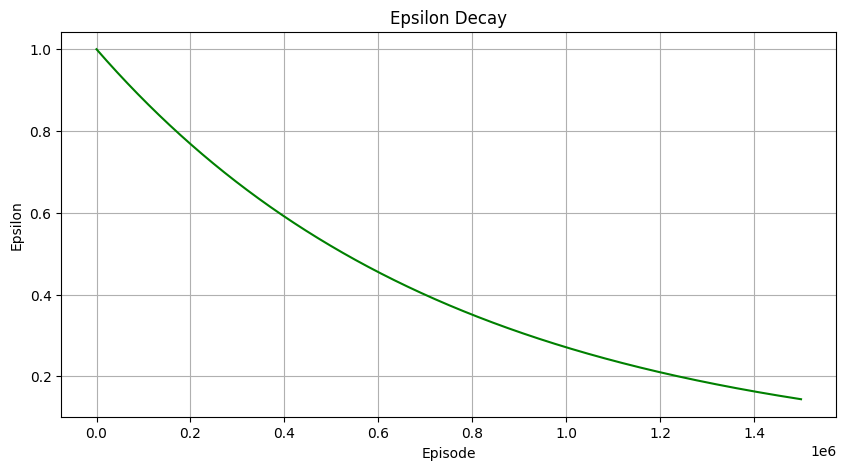

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(agent.epsilon_values, color = 'green')
ax.set_xlabel('Episode')
ax.set_ylabel('Epsilon')
ax.set_title('Epsilon Decay')
ax.grid()
plt.show()

### Experiments:


**1. Randomly selecting Action = 28% Winning rate**


#### Basic Strategy 


**1. Basic Strategy without learning = 42.5% Winning rate**

**2. Basic Strategy - Q Learing (Epsilon greedy Approach):**
        
        For (N = 100000) = 38% Winning rate 
        
        For (N =1000000) = 41.9% Winning rate
        
        For (N =1500000) = 41% Winning rate
        
**3. Basic Strategy - SARSA:**
        
        For (N = 100000) = 38% Winning rate 
        
        For (N =1000000) = 40% Winning rate
        
        For (N =1500000) = 41% Winning rate
        
**4. Basic Strategy - Q learning - The hard action and soft action is implemented according to book rules**
        
        For (N = 100000) = 39% Winning rate
        
        For (N =1000000) = 43% Winning rate (best)
        
        For (N =1500000) = 43.62% Winning rate

### Complete Point Count System:

In [12]:
class BlackjackEnvCardCounting:
    def __init__(self):
        # initializing state variables, create a shuffled deck
        self.deck = self.create_deck()
        self.player_cards = []
        self.dealer_cards = []
        self.split_cards = []
        self.has_doubled_down = False
        
        # initializing to store the rewards and lengths of hands.
        self.rewards = []  
        self.hand_lengths = []  
        
        # reset
        self.reset_game()

    def create_deck(self):
        # creating a new shuffled deck of 52 cards.
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = [f'{value}_{suit}' for value in values for suit in suits]
        random.shuffle(deck)
        return deck

    def draw_single_card(self):
        # Drawing a card from the top of the deck, reshuffling if the deck is empty.
        if not self.deck:
            self.deck = self.create_deck()
        return self.deck.pop()

    def reset_game(self):
        # Resetting the game by shuffling the deck and dealing initial hands to the player and dealer.
        self.deck = self.create_deck()
        self.player_cards = [self.draw_single_card(), self.draw_single_card()]
        self.dealer_cards = [self.draw_single_card(), self.draw_single_card()]

    def get_card_value(self, card):
        # Returning the numeric value of a card (e.g., 'king' returns 10, 'ace' returns 11).
        value, suit = card.split('_')
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def calculate_hand_value(self, hand):
        # the total value of a hand and adjusting for aces
        value = sum(self.get_card_value(card) for card in hand)
        if value > 21 and 'ace' in [card.split('_')[0] for card in hand]:
            value -= 10
        return value
    
    def is_soft_hand(self, hand):
        # if a hand is 'soft', it means it includes an ace counted as 11 without busting.
        return 'ace' in [card.split('_')[0] for card in hand] and self.calculate_hand_value(hand) <= 21 

    def check_busted(self, hand):
        # if a hand's value exceeds 21, then it means the player or dealer busts.
        return self.calculate_hand_value(hand) > 21

    def dealer_plays(self):
        # dealer hits till he reaches a soft 17.
        while self.calculate_hand_value(self.dealer_cards) < 17:
            self.dealer_cards.append(self.draw_single_card())
       #soft17            
#     def dealer_plays(self):
#         # dealer hits until reaching a hard 17 or stands on a soft 17
#         while self.calculate_hand_value(self.dealer_cards) < 17 or (self.calculate_hand_value(self.dealer_cards) == 17 and self.is_soft_hand(self.dealer_cards)):
#             if self.calculate_hand_value(self.dealer_cards) == 17 and self.is_soft_hand(self.dealer_cards):
#                 break  # stand on soft 17
#             self.dealer_cards.append(self.draw_single_card())

    def is_hand_pair(self, hand):
        # if the player's two-card hand consists of pairs
        if len(hand) == 2:
            return hand[0].split('_')[0] == hand[1].split('_')[0]

    def take_step(self, action):
        # player's action (hit or stand) and updates states.
        total_count = self.calculate_count(self.player_cards, self.dealer_cards)
        if action == 'hit':
            self.player_cards.append(self.draw_single_card())
            if self.check_busted(self.player_cards):
                reward = -1
                self.hand_lengths.append(len(self.player_cards))
                self.rewards.append(-2 if self.has_doubled_down else reward)
                return 'terminal', -2 if self.has_doubled_down else reward, True
            else:
                return self.get_current_state(), 0, False

        elif action == 'stand':
            self.dealer_plays()
            player_value = self.calculate_hand_value(self.player_cards)
            dealer_value = self.calculate_hand_value(self.dealer_cards)
            if dealer_value > 21 or player_value > dealer_value:
                reward = 1
                self.rewards.append(reward)
                self.hand_lengths.append(len(self.player_cards))
                return 'terminal', reward, True
            elif dealer_value > player_value:
                reward = -1
                self.rewards.append(reward)
                self.hand_lengths.append(len(self.player_cards))
                return 'terminal', reward, True
            else:
                self.rewards.append(0)
                self.hand_lengths.append(len(self.player_cards))
                return 'terminal', 0, True

    def count_hand(self, hand):
        # Counting the values of cards for strategies like betting more or less.
        count = 0
        for card in hand:
            card_value = self.get_card_value(card)
            if card_value in [2, 3, 4, 5, 6]:
                count += 1
            elif card_value in [10, 11]:  # Counting 10s and aces differently.
                count -= 1
        return count

    def calculate_count(self, player_hand, dealer_hand):
        # calculating a score that helps decides the risk for next time
        total_count = self.count_hand(player_hand) + self.count_hand(dealer_hand)
        unseen_cards = len(self.deck) - len(player_hand) - len(dealer_hand)
        if unseen_cards == 0:
            return 0
        return total_count * 100 / unseen_cards
    
    def get_current_state(self):
        # return the current state of the game for the Q-learning agent to make decisions.
        return (self.calculate_hand_value(self.player_cards), self.get_card_value(self.dealer_cards[0]), self.is_soft_hand(self.player_cards), self.calculate_count(self.player_cards, self.dealer_cards))

#### Complete Point count - Q Learning - Hard and Soft hands using book rules

In [13]:
class QLearningAgent_card_counting:
# initialize the Q-learning agent with the given environment and learning parameters
    def __init__(self, env, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha=0.1, gamma=0.99):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.initial_epsilon = initial_epsilon
        self.epsilon = initial_epsilon
        self.num_episodes = num_episodes
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.Q = defaultdict(lambda: [0, 0])
        self.training_error = []
        self.epsilon_list = []
        
# choose an action based on the current state, using separate strategies for soft and hard hands
    def choose_action(self, state):
        if self.env.is_soft_hand(self.env.player_cards):
            soft_action = self.soft_standing_action(state)
            return soft_action
        else: 
            hard_action = self.hard_standing_action(state)
            return hard_action

# rule for choosing an action with a hard hand - taken from book rules - Table 3.1
    def hard_standing_action(self, state):
        player_hand_value = state[0]
        dealers_hand = state[1]
        if player_hand_value <= 11:
            return 'hit'
        elif player_hand_value >= 17: 
            return 'stand'
        elif 12 <= player_hand_value <= 16 and dealers_hand >= 7:
            return 'hit'
        elif 12 <= player_hand_value <= 17 and 4 <= dealers_hand <= 6:
            return 'stand'
        elif 13 <= player_hand_value <= 17 and (dealers_hand == 2 or dealers_hand == 3):
            return 'stand'
        elif player_hand_value == 12 and (dealers_hand == 2 or dealers_hand == 3):
            return 'hit'
        else:
            return 'hit'  # default action

# rule for choosing an action with a soft hand - taken from book rules -table 3.2
    def soft_standing_action(self, state):
        player_hand_value = state[0]
        dealer_hand = state[1]
        if player_hand_value <= 17:
            return 'hit'
        elif player_hand_value == 18 and (dealer_hand == 9 or dealer_hand == 10):
            return 'hit'
        else:
            return 'stand'
#Q values updation
    def update(self, state, action, next_state, reward):
        action_index = 0 if action == 'hit' else 1
        current_q = self.Q[state][action_index]
        next_q = max(self.Q[next_state])
        temporal_difference = reward + self.gamma * next_q - current_q
        self.Q[state][action_index] += self.alpha * temporal_difference
        self.training_error.append(temporal_difference)

# decaying the epsilon value to reduce exploration over time
    def decay_epsilon(self, episode):
        self.epsilon = self.final_epsilon + (self.initial_epsilon - self.final_epsilon) * np.exp(-self.epsilon_decay * episode)
        self.epsilon_list.append(self.epsilon)

# Train the Q-learning agent by running the algorithm for number of episodes    
    def train(self, num_episodes):
        for episode in range(num_episodes):
            self.env.reset_game()
            state = self.env.get_current_state()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.take_step(action)
                self.update(state, action, next_state, reward)
                state = next_state  
            self.decay_epsilon(episode)


Card counting technique - hard and soft hands rules adjusted results: Winning rate: 0.4176, Losing rate: 0.5278, Draw rate: 0.0546


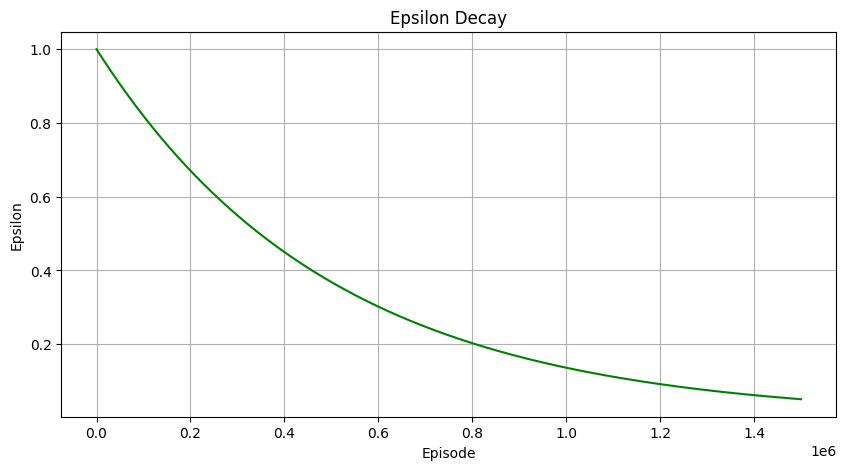

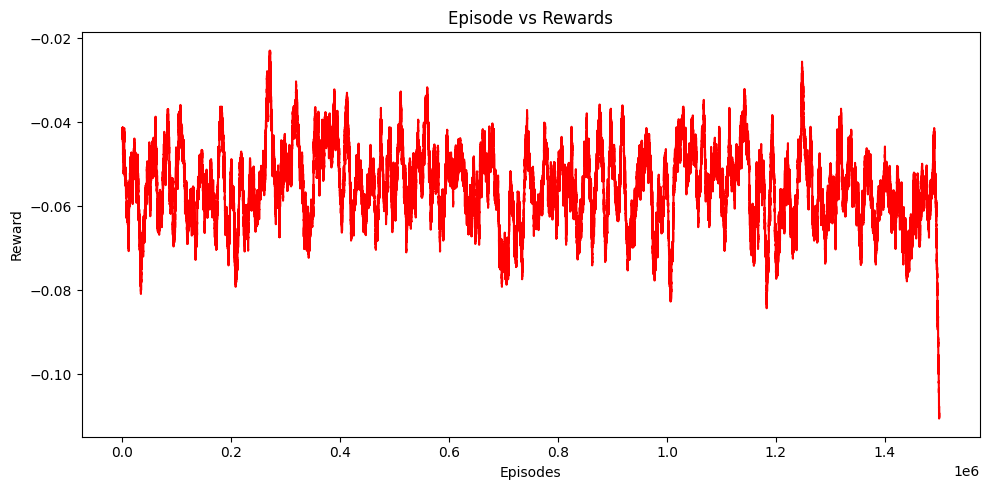

In [14]:
# training phase
num_episodes = 1500000  # training episodes
initial_epsilon = 1.0  # Starting value for epsilon
epsilon_decay = initial_epsilon / (num_episodes / 3)  # Epsilon decay rate
final_epsilon = 0.001  # Minimum value of epsilon
alpha = 0.1
gamma = 0.9

# Call the environment
env = BlackjackEnvCardCounting()
agent = QLearningAgent_card_counting(env, num_episodes, initial_epsilon, epsilon_decay, final_epsilon)

# training
agent.train(num_episodes)

# evaluating after training
num_games = 10000  # games to evaluate the trained agent
win_count = 0
loss_count = 0
draw_count = 0

# Playing games with the trained agent
for _ in range(num_games):
    env.reset_game()
    state = env.get_current_state()
    game_done = False
    while not game_done:
        action = max(['hit', 'stand'], key=lambda action: agent.Q[state][0] if action == 'hit' else agent.Q[state][1])
        state, reward, game_done = env.take_step(action)
    if reward > 0:
        win_count += 1
    elif reward < 0:
        loss_count += 1
    else:
        draw_count += 1

# Calculating win, loss, and draw rates
win_rate = win_count / num_games
loss_rate = loss_count / num_games
draw_rate = draw_count / num_games

# Printing evaluation results
print(f"Card counting technique - hard and soft hands rules adjusted results: Winning rate: {win_rate:.4f}, Losing rate: {loss_rate:.4f}, Draw rate: {draw_rate:.4f}")

# Visualize the epsilon decay
epsilon_values = agent.epsilon_list
plt.figure(figsize=(10, 5))
plt.plot(epsilon_values, color='green')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay')
plt.grid()
plt.show()

length_step = 10000
reward_moving_avg = (np.convolve(np.array(env.rewards).flatten(), np.ones(length_step), mode="valid") / length_step)
# Create the plot
plt.figure(figsize=(10, 5))
plt.title('Episode vs Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(range(len(reward_moving_avg)), reward_moving_avg, color='red')
plt.tight_layout()
plt.show()

#### Complete Point count - Q Learning(Epsilon Greedy Approach) and SARSA

In [15]:
class QLearningAgentCardCounting:
    def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha=0.1, gamma=0.99):
        # Q learning algorithm parameters and initialize state-action values.
        self.environment = environment
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = initial_epsilon  # Exploration rate
        self.num_episodes = num_episodes  # Total episodes for training
        self.epsilon_decay = epsilon_decay  # Decay rate for epsilon
        self.final_epsilon = final_epsilon  # Minimum value for epsilon
        self.Q_values = {}  # to store Q-values
        self.epsilon_values = []  # to check changes in epsilon

    def get_Q_value(self, state, action):
        # getting the Q-value for the state-action pair, usally it is 0.
        return self.Q_values.get((state, action), 0)

    def select_action(self, state):
        # Choose action based on epsilon-greedy policy
        if np.random.random() < self.epsilon:
            self.epsilon_values.append(self.epsilon)
            return random.choice(['hit', 'stand'])
        else:
            return max(['hit', 'stand'], key=lambda action: self.get_Q_value(state, action))

    def update_Q_value(self, state, action, next_state, reward):
        # Updating Q-values as per outputs
        current_q = self.get_Q_value(state, action)
        next_q = max(self.get_Q_value(next_state, a) for a in ['hit', 'stand'])
        temporal_difference = reward + self.gamma * next_q - current_q
        self.Q_values[(state, action)] = current_q + self.alpha * temporal_difference
        
    def decay_epsilon(self):
        # reducing the exploration rate.
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def train_agent(self, num_episodes):
        # Training the agent over specified number of episodes.
        for episode in range(num_episodes):
            self.environment.reset_game()
            state = self.environment.get_current_state()
            game_done = False
            while not game_done:
                action = self.select_action(state)
                next_state, reward, game_done = self.environment.take_step(action)
                self.update_Q_value(state, action, next_state, reward)
                state = next_state
            self.decay_epsilon()


In [16]:
class SARSAAgentCardCounting:
    def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha=0.1, gamma=0.99):
        # SARSA algorithm parameters and initialize state-action values.
        self.environment = environment
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = initial_epsilon  # Exploration rate
        self.num_episodes = num_episodes  # Total episodes for training
        self.epsilon_decay = epsilon_decay  # Decay rate for epsilon
        self.final_epsilon = final_epsilon  # Minimum value for epsilon
        self.Q_values = {}  # to store Q-values
        self.epsilon_values = []  # to check changes in epsilon

    def get_Q_value(self, state, action):
        # getting the Q-value for the state-action pair, usually it is 0.
        return self.Q_values.get((state, action), 0)

    def select_action(self, state):
        # Choose action based on epsilon-greedy policy
        if np.random.random() < self.epsilon:
            self.epsilon_values.append(self.epsilon)
            return random.choice(['hit', 'stand'])
        else:
            return max(['hit', 'stand'], key=lambda action: self.get_Q_value(state, action))

    def update_Q_value(self, state, action, next_state, next_action, reward):
        # Updating Q-values as per SARSA update rule
        current_q = self.get_Q_value(state, action)
        next_q = self.get_Q_value(next_state, next_action)
        temporal_difference = reward + self.gamma * next_q - current_q
        self.Q_values[(state, action)] = current_q + self.alpha * temporal_difference
        
    def decay_epsilon(self):
        # reducing the exploration rate.
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def train_agent(self, num_episodes):
        # Training the agent over specified number of episodes.
        for episode in range(num_episodes):
            self.environment.reset_game()
            state = self.environment.get_current_state()
            action = self.select_action(state)
            game_done = False
            while not game_done:
                next_state, reward, game_done = self.environment.take_step(action)
                next_action = self.select_action(next_state)
                self.update_Q_value(state, action, next_state, next_action, reward)
                state = next_state
                action = next_action
            self.decay_epsilon()

Card counting technique results - epsilon greedy: Winning rate: 0.4404, Losing rate: 0.4650, Draw rate: 0.0946


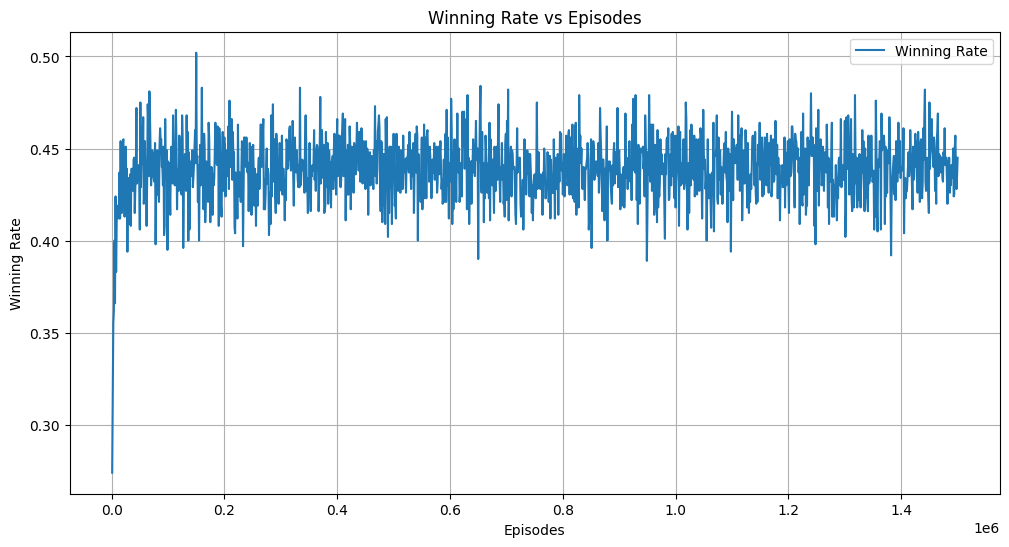

In [17]:
# Training phase
num_episodes = 1500000  # Training episodes
initial_epsilon = 1.0  # Starting value for epsilon
epsilon_decay = initial_epsilon / (num_episodes / 3)  # Epsilon decay rate
final_epsilon = 0.001  # Minimum value of epsilon
alpha = 0.1
gamma = 0.9

# Call the environment
env = BlackjackEnvCardCounting()
agent = QLearningAgentCardCounting(env, num_episodes, initial_epsilon, epsilon_decay, final_epsilon)
# Please uncomment below if you are training SARSA agent and comment above line
#agent = SARSAAgentCardCounting(env, num_episodes, initial_epsilon, epsilon_decay, final_epsilon)

# Variables to store the results
episode_numbers = []
winning_rates = []

# Training with periodic evaluation
evaluation_interval = 1000  # Interval to evaluate the winning rate

for episode in range(1, num_episodes + 1):
    agent.train_agent(1)

    if episode % evaluation_interval == 0:
        # Evaluating agent performance
        win_count = 0
        loss_count = 0
        draw_count = 0
        num_games = 1000  # Games to evaluate the trained agent

        for _ in range(num_games):
            env.reset_game()
            state = env.get_current_state()
            game_done = False
            while not game_done:
                action = max(['hit', 'stand'], key=lambda action: agent.get_Q_value(state, action))
                state, reward, game_done = env.take_step(action)
            if reward > 0:
                win_count += 1
            elif reward < 0:
                loss_count += 1
            else:
                draw_count += 1

        winning_rate = win_count / num_games
        episode_numbers.append(episode)
        winning_rates.append(winning_rate)

# Evaluating after training
num_games = 100000  # Games to evaluate the trained agent
win_count = 0
loss_count = 0
draw_count = 0

# Playing games with the trained agent
for _ in range(num_games):
    env.reset_game()
    state = env.get_current_state()
    game_done = False
    while not game_done:
        action = max(['hit', 'stand'], key=lambda action: agent.get_Q_value(state, action))
        state, reward, game_done = env.take_step(action)
    if reward > 0:
        win_count += 1
    elif reward < 0:
        loss_count += 1
    else:
        draw_count += 1

# Calculating win, loss, and draw rates
winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

# Printing evaluation results
print(f"Card counting technique results - epsilon greedy: Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")
# Please uncomment below if you are training SARSA agent and comment above line
#print(f"Card counting technique results - SARSA: Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(episode_numbers, winning_rates, label='Winning Rate')
plt.xlabel('Episodes')
plt.ylabel('Winning Rate')
plt.title('Winning Rate vs Episodes')
plt.legend()
plt.grid(True)
plt.show()


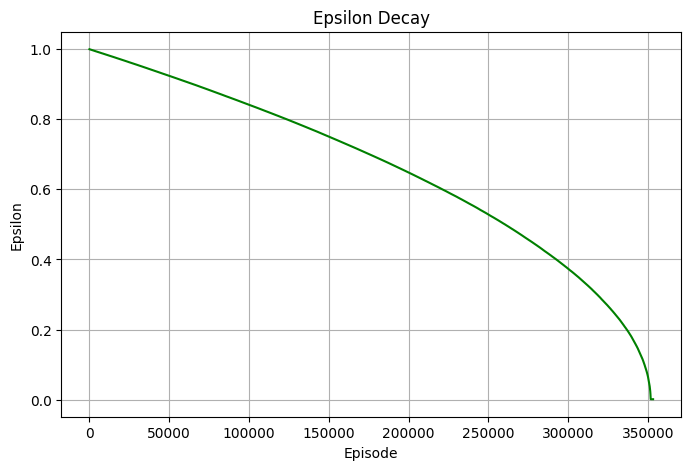

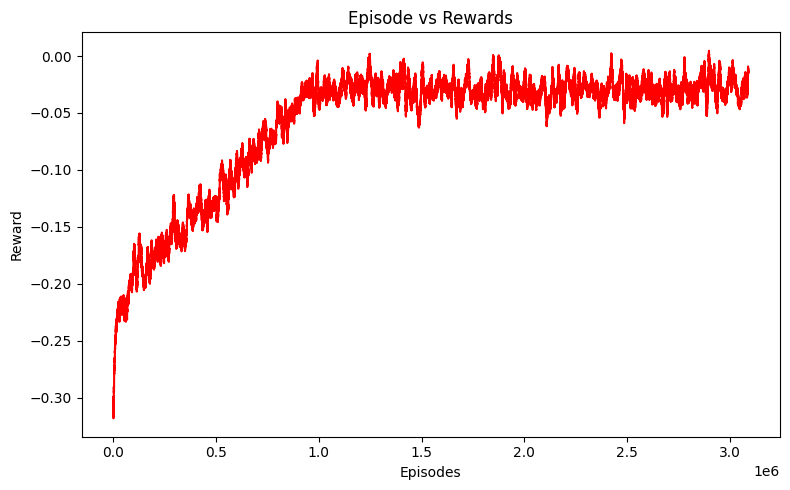

In [18]:
# Visualize the epsilon decay
epsilon_values = agent.epsilon_values
plt.figure(figsize=(8, 5))
plt.plot(epsilon_values, color='green')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay')
plt.grid()
plt.show()

length_step = 10000
reward_moving_avg = (np.convolve(np.array(env.rewards).flatten(), np.ones(length_step), mode="valid") / length_step)
# Create the plot
plt.figure(figsize=(8, 5))
plt.title('Episode vs Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(range(len(reward_moving_avg)), reward_moving_avg, color='red')
plt.tight_layout()
plt.show()

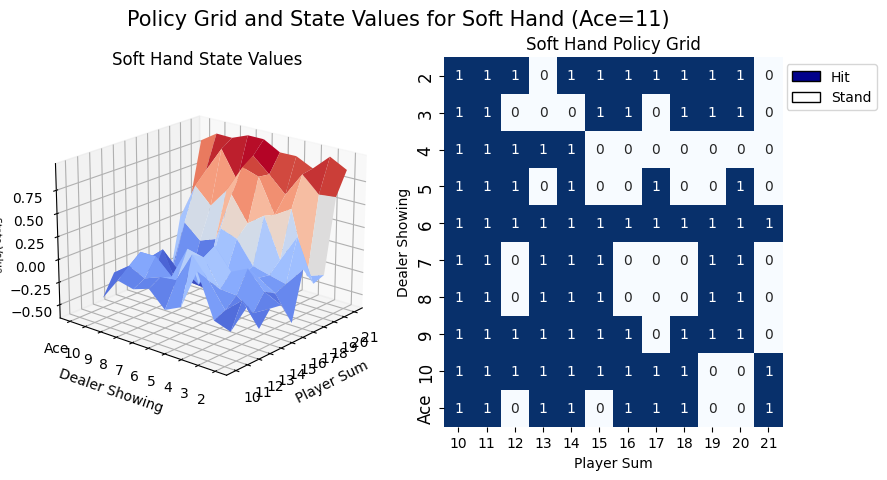

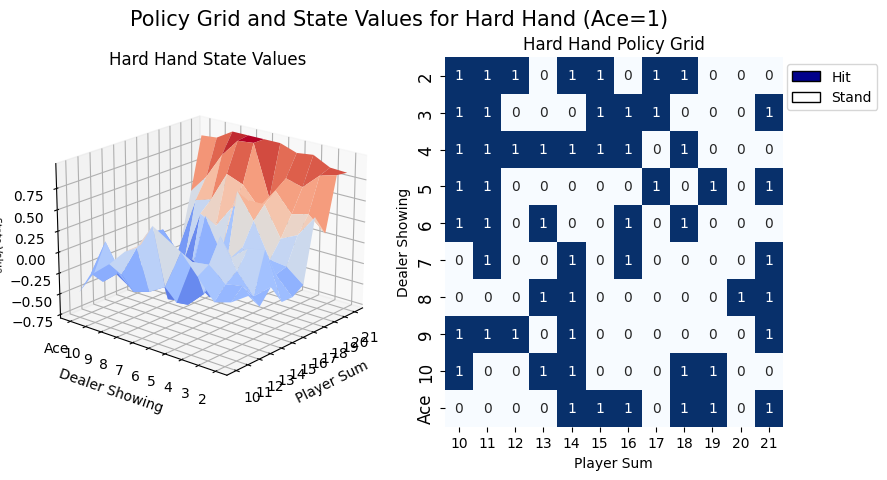

In [19]:
# value and policy grids
state_values = defaultdict(float)
policy = defaultdict(int)
# loop for Q-values to set state values and policy
for state_action in agent.Q_values.keys():
    state, action = state_action
    if state not in policy:
        state_values[state] = max(agent.Q_values.get((state, a), 0) for a in ['hit', 'stand'])
        policy[state] = 1 if action == 'hit' else 0

player_sums, dealer_shows = np.meshgrid(
    np.arange(10, 22),
    np.arange(2, 12),
)
# value grid for soft hands
value_grid_soft = np.apply_along_axis(
    lambda state: state_values.get((state[0], state[1], True, 0)),
    axis=2,
    arr=np.dstack([player_sums, dealer_shows]),
)
# policy grid for soft hands
policy_grid_soft = np.apply_along_axis(
    lambda state: policy.get((state[0], state[1], True, 0), 1),
    axis=2,
    arr=np.dstack([player_sums, dealer_shows]),
)
# value grid for hard hands
value_grid_hard = np.apply_along_axis(
    lambda state: state_values.get((state[0], state[1], False, 0)),
    axis=2,
    arr=np.dstack([player_sums, dealer_shows]),
)
# policy grid for hard hands
policy_grid_hard = np.apply_along_axis(
    lambda state: policy.get((state[0], state[1], False, 0), 1),
    axis=2,
    arr=np.dstack([player_sums, dealer_shows]),
)

# Plot value and policy grids for soft hand
fig = plt.figure(figsize=plt.figaspect(0.5))
fig.suptitle("Policy Grid and State Values for Soft Hand (Ace=11)", fontsize=15)

# Plot state values for soft hand
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(player_sums, dealer_shows, value_grid_soft, cmap='coolwarm')
ax1.set_xticks(range(10, 22))
ax1.set_xticklabels(range(10, 22))
ax1.set_yticks(range(2, 12))
ax1.set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"])
ax1.set_title("Soft Hand State Values")
ax1.set_xlabel("Player Sum")
ax1.set_ylabel("Dealer Showing")
ax1.set_zlabel("State Value", fontsize=7)
ax1.view_init(20, 220)

# Plot policy for soft hand
ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(policy_grid_soft, linewidth=0, annot=True, cmap="Blues", cbar=False, ax=ax2)
ax2.set_title("Soft Hand Policy Grid")
ax2.set_xlabel("Player Sum")
ax2.set_ylabel("Dealer Showing")
ax2.set_xticks(np.arange(0.5, len(range(10, 22)), 1))
ax2.set_xticklabels(range(10, 22))
ax2.set_yticks(np.arange(0.5, len(range(2, 12)), 1))
ax2.set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"], fontsize=12)
legend_elements = [
    Patch(facecolor="darkblue", edgecolor="black", label="Hit"),
    Patch(facecolor="white", edgecolor="black", label="Stand"),
]
ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

plt.show()

# Plot value and policy grids for hard hand
fig = plt.figure(figsize=plt.figaspect(0.5))
fig.suptitle("Policy Grid and State Values for Hard Hand (Ace=1)", fontsize=15)

# Plot state values for hard hand
ax3 = fig.add_subplot(1, 2, 1, projection='3d')
ax3.plot_surface(player_sums, dealer_shows, value_grid_hard, cmap='coolwarm')
ax3.set_xticks(range(10, 22))
ax3.set_xticklabels(range(10, 22))
ax3.set_yticks(range(2, 12))
ax3.set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"])
ax3.set_title("Hard Hand State Values")
ax3.set_xlabel("Player Sum")
ax3.set_ylabel("Dealer Showing")
ax3.set_zlabel("State Value", fontsize=7)
ax3.view_init(20, 220)

# Plot policy for hard hand
ax4 = fig.add_subplot(1, 2, 2)
sns.heatmap(policy_grid_hard, linewidth=0, annot=True, cmap="Blues", cbar=False, ax=ax4)
ax4.set_title("Hard Hand Policy Grid")
ax4.set_xlabel("Player Sum")
ax4.set_ylabel("Dealer Showing")
ax4.set_xticks(np.arange(0.5, len(range(10, 22)), 1))
ax4.set_xticklabels(range(10, 22))
ax4.set_yticks(np.arange(0.5, len(range(2, 12)), 1))
ax4.set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"], fontsize=12)
ax4.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

plt.show()


### Experiments:
      
        
#### Complete Point Count System

**1. Complete Point Count System - Q Learning (Epsilon greedy Approach):**
        
        For (N = 100000) = 39% Winning rate 
        
        For (N =1000000) = 43% Winning rate
        
        For (N =1500000) = 44.53% Winning rate(best)
        
**2. Complete Point Count System - Q learning - The hard action and soft action is implemented according to book rules**
        
        For (N = 100000) = 38% Winning rate
        
        For (N =1000000) = 41.5% Winning rate
        
        For (N =1500000) = 42.51% Winning rate
        
**3. Complete Point Count System - SARSA**
        
        For (N = 100000) = 34% Winning rate
        
        For (N =1000000) = 40.5% Winning rate
        
        For (N =1500000) = 41.31% Winning rate

### Conclusion:
**The Complete Point Count System with Q-learning(epsilon greedy) had the best performance, with a 44.53% winning rate after 1,500,000 games. Basic strategies with Q learning(hard and soft actions as per book rules) is also giving almost 43.5% winning rates.**

# <center>THE END</center>

**Name: THARUN KUMAR KORINE PALLI**

**Matriculation Number: 5123708**

**Email: tharunkumar.korinepalli@study.thws.de**